# Model implementation

Information Geometry Soft Clustering for Sport Analytics

Joaquin Garay

In [3]:
%load_ext autoreload
%autoreload 2

import os
import time
import tqdm
import numpy as np
import pandas as pd

import vis
import softclustering as sc

from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import socceraction.spadl as spadl


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Data Preparation

Concatenate actions of all games in one DataFrame.

In [4]:
datafolder = "data"
fifa2018h5 = os.path.join(datafolder, "spadl-fifa2018.h5")
games = pd.read_hdf(fifa2018h5, key="games")
with pd.HDFStore(fifa2018h5) as store:
    actions = []  #list of DataFrames
    for game in tqdm.tqdm(games.itertuples()):
        game_action = store[f"actions/game_{game.game_id}"]
        game_action = spadl.play_left_to_right(game_action, game.home_team_id)
        game_action["is_home"] = game_action["team_id"] == game.home_team_id
        actions.append(game_action)
    actions = pd.concat(actions)
    actions.drop("original_event_id", axis=1, inplace=True)
    actions = pd.merge(actions, spadl.config.actiontypes_df(), how="left")

64it [00:00, 215.77it/s]


In [5]:
def consolidate(actions):
    #actions.fillna(0, inplace=True)

    #Consolidate corner_short and corner_crossed
    corner_idx = actions.type_name.str.contains("corner")
    actions["type_name"] = actions["type_name"].mask(corner_idx, "corner")

    #Consolidate freekick_short, freekick_crossed, and shot_freekick
    freekick_idx = actions.type_name.str.contains("freekick")
    actions["type_name"] = actions["type_name"].mask(freekick_idx, "freekick")

    #Consolidate keeper_claim, keeper_punch, keeper_save, keeper_pick_up
    keeper_idx = actions.type_name.str.contains("keeper")
    actions["type_name"] = actions["type_name"].mask(keeper_idx, "keeper_action")

    actions["start_x"] = actions["start_x"].mask(actions.type_name == "shot_penalty", 94.5)
    actions["start_y"] = actions["start_y"].mask(actions.type_name == "shot_penalty", 34)

    return actions


actions = consolidate(actions)

In [6]:
#Actions of Team France matches.
len(actions[actions["team_id"] == 771])

6829

In [7]:
actions.groupby("type_name").size()

type_name
bad_touch         1547
clearance         2074
corner             558
cross             1305
dribble          52731
foul              1876
freekick          1272
goalkick           677
interception      1681
keeper_action      584
pass             56438
shot              1556
shot_penalty        68
tackle            1830
take_on           2109
throw_in          2178
dtype: int64

As suggested in SoccerMix, add noise on the starting and ending locations, but only on those actions that we can visually note a predefined pattern.
* *Add noise in both start and end locations*:
    * Cross
    * Shot
    * Keeper_action
* *Only on start locations*:
    * Clearance
    * Goal kick
* *Only on end locations*:
    * Corner
    * Freekick
    * Shot_penalty

In [8]:
def add_noise(actions):
    # Start locations
    start_list = ["cross", "shot", "keeper_action", "clearance", "goalkick"]
    mask = actions["type_name"].isin(start_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["start_x", "start_y"]].shape)
    actions.loc[mask, ["start_x", "start_y"]] += noise

    # End locations
    end_list = ["cross", "shot", "keeper_action", "corner", "freekick", "shot_penalty"]
    mask = actions["type_name"].isin(end_list)
    noise = np.random.normal(0, 0.5, size=actions.loc[mask, ["end_x", "end_y"]].shape)
    actions.loc[mask, ["end_x", "end_y"]] += noise

    return actions


actions = add_noise(actions)

In [9]:
# # display event locations with noise
# corrected_actions = ["cross", "shot", "keeper_action", "clearance", "goalkick","corner", "freekick", "shot_penalty"]
# for actiontype in corrected_actions:
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="start_x",
#         y="start_y",
#         title = f"Start Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()
#     actions[actions.type_name == actiontype].plot.scatter(
#         x="end_x",
#         y="end_y",
#         title = f"End Location: {actiontype}",
#         figsize = (6,4)
#     )
#     plt.show()

In [10]:
def remove_outliers(actions, verbose=False):
    X = actions[["start_x","start_y","end_x","end_y"]].to_numpy(dtype=float)
    inliers = LocalOutlierFactor(contamination="auto").fit_predict(X)
    if verbose:
        print(f"Remove {(inliers==-1).sum()} out of {X.shape[0]} datapoints.")
    return actions[inliers==1]

actions = remove_outliers(actions,True)

Remove 637 out of 128484 datapoints.


### Features

Compute the angle of the direction of the action with respect with the x-axis (pitch's length) a
$$\tan \theta = \frac{y_{end} - y_{start}}{x_{end} - x_{start}}$$

In [11]:
actions["angle"] = np.arctan2(actions.end_y - actions.start_y, actions.end_x - actions.start_x)
actions["cos_angle"] = np.cos(actions["angle"])
actions["sin_angle"] = np.sin(actions["angle"])
actions[["angle", "cos_angle", "sin_angle"]].describe()

,angle,cos_angle,sin_angle
count,127847.000000,127847.000000,127847.000000
mean,0.060702,0.317358,-0.006073
std,1.459602,0.676935,0.664088
min,-3.134950,-1.000000,-1.000000
25%,-0.969342,-0.169098,-0.647648
50%,0.000000,0.532483,0.000000
75%,1.064659,0.956041,0.624209
max,3.141593,1.000000,1.000000


### First run

Let's run a first toy implementation using throw-ins of team France.

In [12]:
mask = (actions["type_name"]=="pass") #& (actions["team_id"]==771)
loc_data = actions[mask][["start_x", "start_y"]]
dir_data = actions[mask][["cos_angle", "sin_angle"]]

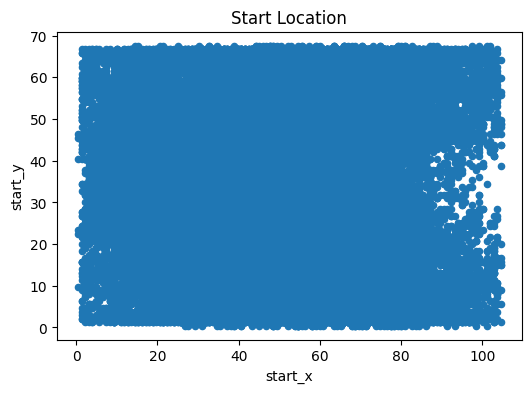

In [13]:
loc_data.plot.scatter(
        x="start_x",
        y="start_y",
        title = f"Start Location",
        figsize = (6,4)
    )
plt.show()

In [14]:
#Gaussian clusters
k_gauss = 4

gauss_clusters = [sc.MultivariateGaussian() for j in range(k_gauss)]

loc_em_model = sc.MixtureModel(gauss_clusters)
loc_bregman_model = sc.MixtureModel(gauss_clusters)

# Classic EM
start = time.time()
res_em = loc_em_model.fit_em_classic(loc_data, verbose=False)
t_em = time.time() - start

# Bregman EM
start = time.time()
res_bregman = loc_bregman_model.fit_em_bregman(loc_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nBregman: {t_bregman:.4f}s")

Final log-likelihoods:
EM: -491071.3980
Bregman: -491071.3980
Timings:
EM: 4.1670s
Bregman: 4.5889s


In [15]:
for model in [loc_em_model, loc_bregman_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=4)
  ├─ (0) w=0.446  MultivariateGaussian(d=2, mean=[54.482 16.806], cov=[[397.046 -35.032], [-35.032 105.628]])
  ├─ (1) w=0.402  MultivariateGaussian(d=2, mean=[52.941 48.45 ], cov=[[407.488  29.145], [29.145 82.595]])
  ├─ (2) w=0.080  MultivariateGaussian(d=2, mean=[17.805 31.467], cov=[[ 69.823 -10.086], [-10.086 235.558]])
  └─ (3) w=0.071  MultivariateGaussian(d=2, mean=[56.458 64.925], cov=[[423.437   0.301], [0.301 1.614]])

MixtureModel(n_clusters=4)
  ├─ (0) w=0.446  MultivariateGaussian(d=2, mean=[54.482 16.806], cov=[[397.046 -35.032], [-35.032 105.628]])
  ├─ (1) w=0.402  MultivariateGaussian(d=2, mean=[52.941 48.45 ], cov=[[407.488  29.145], [29.145 82.595]])
  ├─ (2) w=0.080  MultivariateGaussian(d=2, mean=[17.805 31.467], cov=[[ 69.823 -10.086], [-10.086 235.558]])
  └─ (3) w=0.071  MultivariateGaussian(d=2, mean=[56.458 64.925], cov=[[423.437   0.301], [0.301 1.614]])



In [16]:
loc_em_model.get_posteriors(loc_data)

array([[4.31007910e-001, 5.68886598e-001, 1.05492107e-004,
        1.60154616e-125],
       [4.26406065e-001, 5.70254187e-001, 3.33974730e-003,
        1.52437242e-125],
       [9.79239205e-001, 1.64994865e-002, 4.26130858e-003,
        3.09130463e-252],
       ...,
       [9.99973062e-001, 2.69380522e-005, 4.12050594e-020,
        0.00000000e+000],
       [9.88606187e-001, 1.13938131e-002, 6.27453449e-018,
        6.52710205e-233],
       [5.04356695e-001, 4.95571662e-001, 7.16427949e-005,
        1.37929457e-132]])

In [17]:
#Von Mises Clusters
k_vm = 3

vm_clusters = [sc.VonMises() for _ in range(k_vm)]

dir_em_model = sc.MixtureModel(vm_clusters)
dir_proxy_model = sc.MixtureModel(vm_clusters)
dir_bregman_model = sc.MixtureModel(vm_clusters)

# Classic EM
start = time.time()
res_em = dir_em_model.fit_em_classic(dir_data, verbose=False)
t_em = time.time() - start

# Proxy EM for Von Mises
start = time.time()
res_proxy = dir_proxy_model.fit_em_vonmises_approx(dir_data, verbose=False)
t_proxy = time.time() - start

# Bregman EM
start = time.time()
res_bregman = dir_bregman_model.fit_em_bregman(dir_data, verbose=False)
t_bregman = time.time() - start

# Results
print(f"Final log-likelihoods:\nEM: {res_em[-1]:.4f}\nProxy: {res_proxy[-1]:.4f}\nBregman: {res_bregman[-1]:.4f}")
print(f"Timings:\nEM: {t_em:.4f}s\nProxy: {t_proxy:.4f}s\nBregman: {t_bregman:.4f}s")


Final log-likelihoods:
EM: -100687.3022
Proxy: -100514.3424
Bregman: -100687.2864
Timings:
EM: 3.9722s
Proxy: 2.1521s
Bregman: 2.2930s


In [18]:
for model in [dir_em_model, dir_bregman_model, dir_proxy_model]:
    print(f"{model}\n")

MixtureModel(n_clusters=3)
  ├─ (0) w=0.371  VonMises(loc=29.8º, kappa=1.179)
  ├─ (1) w=0.307  VonMises(loc=-70.7º, kappa=1.314)
  └─ (2) w=0.322  VonMises(loc=97.9º, kappa=0.442)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.371  VonMises(loc=29.8º, kappa=1.179)
  ├─ (1) w=0.307  VonMises(loc=-70.7º, kappa=1.314)
  └─ (2) w=0.322  VonMises(loc=97.9º, kappa=0.442)

MixtureModel(n_clusters=3)
  ├─ (0) w=0.027  VonMises(loc=29.8º, kappa=1.179)
  ├─ (1) w=0.057  VonMises(loc=-70.7º, kappa=1.314)
  └─ (2) w=0.916  VonMises(loc=97.9º, kappa=0.442)



In [19]:
dir_bregman_model.get_weights()

array([0.37148491, 0.30653785, 0.32197724])

In [20]:
dir_bregman_model.get_posteriors(dir_data)

array([[0.16531505, 0.27262303, 0.56206192],
       [0.12470611, 0.65292088, 0.22237301],
       [0.23926117, 0.5939932 , 0.16674563],
       ...,
       [0.425091  , 0.06079984, 0.51410916],
       [0.55203131, 0.23534496, 0.21262373],
       [0.19124852, 0.19119877, 0.61755271]])

In [50]:
K_loc = 4
K_dir = 4
choose = "bregman"
start = time.time()
gmm, vmm_list = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start
print(f"Running Time {choose} Model: {run_time:.4f}s\n")
print(f"{gmm}\n")
for i, vmm in enumerate(vmm_list):
    print(f"GMM Cluster {i}: ")
    print(f"{vmm}\n")

Running Time bregman Model: 16.7098s

MixtureModel(n_clusters=4)
  ├─ (0) w=0.446  MultivariateGaussian(d=2, mean=[54.482 16.806], cov=[[397.046 -35.032], [-35.032 105.628]])
  ├─ (1) w=0.402  MultivariateGaussian(d=2, mean=[52.941 48.45 ], cov=[[407.488  29.145], [29.145 82.595]])
  ├─ (2) w=0.080  MultivariateGaussian(d=2, mean=[17.805 31.467], cov=[[ 69.823 -10.086], [-10.086 235.558]])
  └─ (3) w=0.071  MultivariateGaussian(d=2, mean=[56.458 64.925], cov=[[423.437   0.301], [0.301 1.614]])

GMM Cluster 0: 
MixtureModel(n_clusters=4)
  ├─ (0) w=0.227  VonMises(loc=5.2º, kappa=4.390)
  ├─ (1) w=0.177  VonMises(loc=159.4º, kappa=3.034)
  ├─ (2) w=0.355  VonMises(loc=84.8º, kappa=3.373)
  └─ (3) w=0.241  VonMises(loc=-61.1º, kappa=3.105)

GMM Cluster 1: 
MixtureModel(n_clusters=4)
  ├─ (0) w=0.448  VonMises(loc=34.4º, kappa=1.909)
  ├─ (1) w=0.224  VonMises(loc=-144.7º, kappa=1.484)
  ├─ (2) w=0.094  VonMises(loc=-31.2º, kappa=1.089)
  └─ (3) w=0.234  VonMises(loc=-82.1º, kappa=4.074)


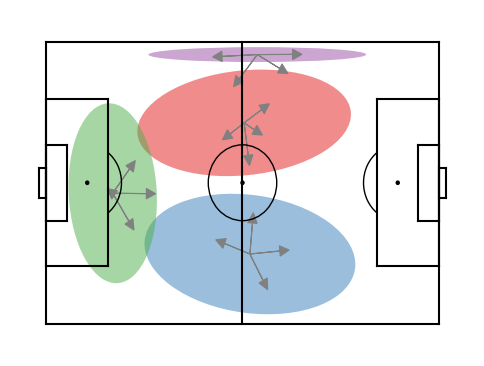

In [51]:
vis.show_all_models(gmm, vmm_list)

In [46]:
choose = "soccermix"
start = time.time()
gmm, vmm_list = sc.two_layer_scheme(loc_data, dir_data, K_loc, K_dir, choose=choose)
run_time = time.time() - start
print(f"Running Time {choose} Model: {run_time:.4f}s\n")
print(f"{gmm}\n")
for i, vmm in enumerate(vmm_list):
    print(f"GMM Cluster {i}: ")
    print(f"{vmm}\n")

Running Time soccermix Model: 15.3782s

MixtureModel(n_clusters=4)
  ├─ (0) w=0.446  MultivariateGaussian(d=2, mean=[54.482 16.806], cov=[[397.046 -35.032], [-35.032 105.628]])
  ├─ (1) w=0.402  MultivariateGaussian(d=2, mean=[52.941 48.45 ], cov=[[407.488  29.145], [29.145 82.595]])
  ├─ (2) w=0.080  MultivariateGaussian(d=2, mean=[17.805 31.467], cov=[[ 69.823 -10.086], [-10.086 235.558]])
  └─ (3) w=0.071  MultivariateGaussian(d=2, mean=[56.458 64.925], cov=[[423.437   0.301], [0.301 1.614]])

GMM Cluster 0: 
MixtureModel(n_clusters=4)
  ├─ (0) w=0.215  VonMises(loc=6.7º, kappa=7.600)
  ├─ (1) w=0.321  VonMises(loc=141.0º, kappa=1.937)
  ├─ (2) w=0.232  VonMises(loc=75.4º, kappa=6.680)
  └─ (3) w=0.232  VonMises(loc=-59.5º, kappa=4.712)

GMM Cluster 1: 
MixtureModel(n_clusters=4)
  ├─ (0) w=0.205  VonMises(loc=52.7º, kappa=6.394)
  ├─ (1) w=0.072  VonMises(loc=-85.6º, kappa=16.054)
  ├─ (2) w=0.639  VonMises(loc=-87.0º, kappa=0.674)
  └─ (3) w=0.085  VonMises(loc=-3.0º, kappa=10.855

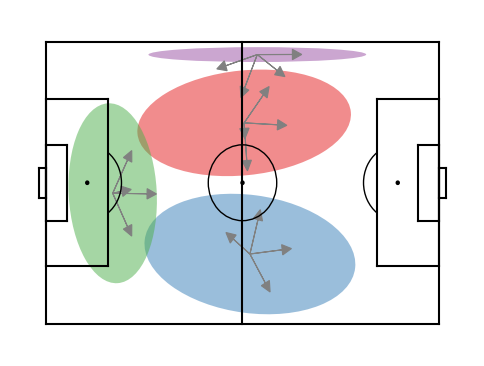

In [48]:
vis.show_all_models(gmm, vmm_list)